### Задача

Правда ли бикас дает преимущество? Или лучше разгонять без всяких там бикасов

In [1]:
import os
wd = os.getcwd()
wd = os.path.dirname(os.path.dirname(wd))
import sys
sys.path.append(wd+"\\src\\")

In [2]:
from tube import InterpXY,Tube,BorderSimple
from math import *
import numpy as np
from powderlayer import PowderBD, PowderOvLayer, Powder
from gaslayer import GasEOS, GasLayer
from pistonlayer import ElPistEOS, ElPistLayer
import pprint as pp

In [3]:
from tqdm import tqdm_notebook
from matplotlib.patches import Polygon
import matplotlib as mpl
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed
import ipywidgets

%matplotlib inline 
%config InlineBackend.figure_format = 'svg' 

mpl.rcParams['figure.figsize'] = (5,3) 

In [4]:
import json
from functional import seq

#### Простая цилиндрическая пушка

q_max = 0.12166999999999997


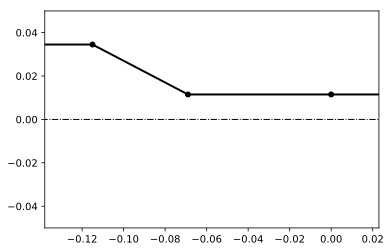

In [60]:
d = 23e-3
C_q_max = 10
q_max = C_q_max * (d*10)**3
print(f'q_max = {q_max}')


tube_dict = {
    'tube_points': [[-d*100,3*d],[-d*5,3*d],[-3*d,d],[0, d], [300*d, d]]
}
tube = Tube.get_standart(tube_dict)
ax, fig = plt.subplots()
tube.plot(ax, fig)
fig.set_ylim(-0.05,0.05)
fig.set_xlim(-6*d,d)
plt.show()

In [61]:
a1 = np.linspace(0,1,5)
a2 = np.linspace(0,1,5)
np.concatenate([a1, a2])

array([0.  , 0.25, 0.5 , 0.75, 1.  , 0.  , 0.25, 0.5 , 0.75, 1.  ])

In [66]:
gas_layer_dict = {
    'type': 'gas',
    'name': 'He',
    'gamma': 1.66,
    'kappa': 0.005925,
    'R': 2078,
    'T_0': 300, # K
    'W_0': 0.0003,  # м^3 объем газа
    'p_0': 100e6, # начальное давление газа
    'u_0': 0,     #начальная скорость
    'x_2': 0
}

index_anchor = 150
calc_settings = {
    'cell_dx': 0.0025,
    'n_cells': 200,
    'n_cells_min': 13,
    'n_cells_max': 200,
    'GasFluxCalculator_kwargs': {'flux_type':2, 'x_order':1},
    'GridStrecher_kwargs': {'strech_type': 3, 'index_anchor':index_anchor}
} 

ro_0 = gas_layer_dict['p_0']/(gas_layer_dict['R']*gas_layer_dict['T_0'] + gas_layer_dict['p_0']*gas_layer_dict['kappa'])
omega = q_max * 3
gas_layer_dict['W_0'] = omega / ro_0
x1 = tube.get_x1(gas_layer_dict['x_2'], gas_layer_dict['W_0'])

gl = GasLayer.get_standart(tube, x1, gas_layer_dict, calc_settings)   
xs_bord0 = np.linspace(x1, -10*d, 2*(index_anchor+1)//3)
xs_bord1 = np.linspace(-10*d, -2*d, (index_anchor+1)-len(xs_bord0)+1)[1:]
xs_bord2 = np.linspace(-2*d, gas_layer_dict['x_2'], gl.n_cells-index_anchor+1)[1:]
xs_bord = np.concatenate([xs_bord0, xs_bord1, xs_bord2])
gl.xs_borders[:] = xs_bord
gl.init_SsdW()
gl.init_q()
gl.init_taus_acustic()
# fig, ax = plt.subplots()
# tube.plot(fig, ax)
# gl.plot(fig, ax)
# ax.set_ylim(-0.01,0.05)
# ax.set_xlim(-100*d,120*d)
# plt.show()

gl.xs_borders.shape, xs_bord.shape, xs_bord[index_anchor]+2*d, xs_bord[-1]

((201,), (201,), 0.0, 0.0)

In [67]:
lrs = [gl]
b = BorderSimple(gl, None, q_max, 0)
vl = 0
for i in tqdm_notebook(range(15000)):
    if lrs[-1].xs_borders[-1] > tube.get_xs()[-1]:
        break
    tau = lrs[-1].get_tau_min()*0.4
    b.update_xs()
    b.update_Vs(tau)
    gl = gl.step_up(tau, False)
    lrs.append(gl)
    b.lr_left = gl
    
 

In [68]:
@interact(ind=ipywidgets.IntSlider(min=0,max=len(lrs)-1,step=100, value=0))
def plotMe(ind):
    
    lr = lrs[ind]
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(10,7), gridspec_kw={'height_ratios':[2, 2, 1]})
    tube.plot(fig, ax2)
    ax2.set_ylim(-0.005, 0.09)
    lr.plot(fig, ax2)
    
    param_name = 'us'

    xs = np.array(lr.xs_borders)
    ys = np.array(lr.Vs_borders)
    color = lr.color_4_plot
    lw = 2
    ax0.scatter(xs, ys, color=color, label=f'Vs')
    xs = np.array(lr.xs_cells)
    ys = np.array(getattr(lr, param_name))
    ax0.plot(xs, ys, color=color, lw=lw, label=f'{param_name} газ')

    ax0.grid(True)
    ax0.set_ylabel(param_name)
#     ax0.set_ylim(900,1000)
    ax0.set_title(f't={lr.time*1000} ms; i={ind}')
    ax0.legend()
    
    param_name = 'es'
    xs = np.array(lr.xs_cells)
    ys = np.array(getattr(lr, param_name))
    color = lr.color_4_plot
    lw = 2
    ax1.plot(xs, ys/1e5, color=color, lw=lw, label=f'{param_name} газ')
    
    
    ax1.grid(True)
    ax1.set_ylabel(f'$p$, атм.')
#     ax1.set_ylim(-500,700)
#     ax1.set_title(f't={lr.time*1000} ms; i={ind}')
    ax1.legend()
    plt.show()

interactive(children=(IntSlider(value=0, description='ind', max=13569, step=100), Output()), _dom_classes=('wi…

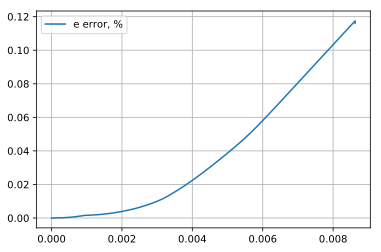

In [70]:
xs = [lr.time for lr in lrs]
epot = np.array([lr.get_E_potential() for lr in lrs])
ekinet =np.array([lr.get_E_kinetic()  for lr in lrs])
esum =np.array([(lr.get_E_sum() + b.mass*lr.Vs_borders[-1]**2/2-lrs[0].get_E_sum())/lrs[0].get_E_sum()*100  for lr in lrs])    
# plt.plot(xs, epot, label='epot')
# plt.plot(xs, ekinet, label='ekinet')
plt.plot(xs, esum, label='e error, %')
plt.legend()
plt.grid()
plt.show()